In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from math import radians, cos, sin, asin, sqrt
%matplotlib inline

from scipy.spatial import cKDTree
from tqdm import tqdm


In [ ]:
# !conda install cartopy
from cartopy import config
import cartopy.crs as ccrs


ModuleNotFoundError: ignored

In [ ]:
data = pd.read_csv (r'osm_data.csv')
df = pd.DataFrame(data, columns = ['id', 'latitude', 'longitude', 'description'])

In [ ]:
vnf_data = pd.read_csv(r'vnf_2017.csv')
vnf_df = pd.DataFrame(vnf_data, columns=['id_Key', 'Date_Mscan','Lat_GMTCO','Lon_GMTCO','Temp_BB', 'RHI', 'RH', 'Area_BB', 'Cloud_Mask', 'Sample_M10'])
vnf_df.drop(vnf_df[vnf_df['Temp_BB'] == 999999].index, inplace = True)
vnf_lats = vnf_df['Lat_GMTCO']
vnf_long = vnf_df['Lon_GMTCO']                   

In [ ]:
heat = vnf_df['Temp_BB'].to_numpy()
marker_size = [2*np.log(s) for s in heat]

In [ ]:
of = df.loc[df['description'] == 'oil_field']
lat_of = of['latitude']
long_of = of['longitude']

rig = df.loc[df['description'] == 'rig']
lat_rig = rig['latitude']
long_rig = rig['longitude']

op = df.loc[df['description'] == 'offshore_platform']
lat_op = op['latitude']
long_op = op['longitude']

flare = df.loc[df['description'] == 'flare']
lat_f = flare['latitude']
long_f = flare['longitude']

uk = df.loc[df['description'] == 'unknown']
lat_uk = uk['latitude']
long_uk = uk['longitude']

gf = df.loc[df['description'] == 'gas_field']
lat_gf = gf['latitude']
long_gf = gf['longitude']


In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)

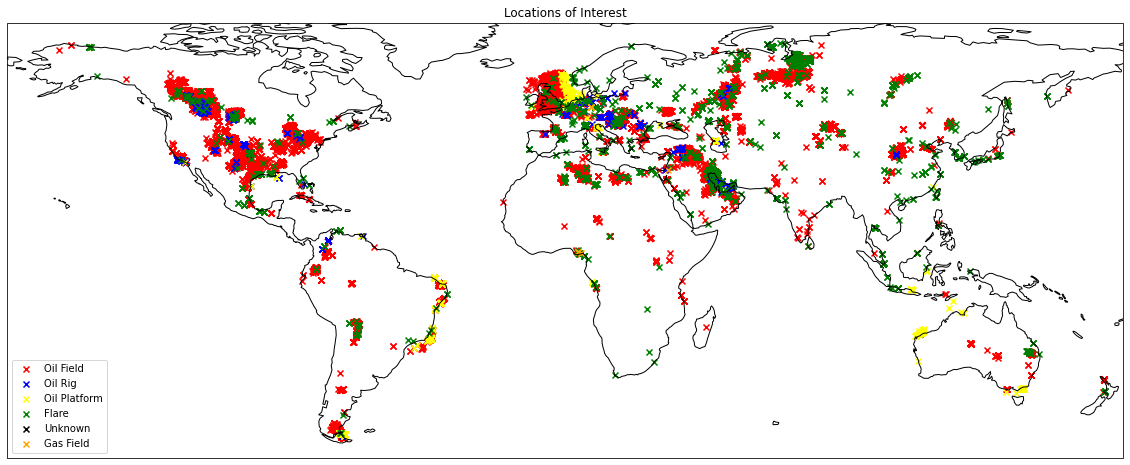

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Locations of Interest')
ax.coastlines(resolution='110m')
plt.scatter(long_of, lat_of, marker='x', color='red', label='Oil Field')
plt.scatter(long_rig, lat_rig, marker='x', color='blue', label='Oil Rig')
plt.scatter(long_op, lat_op, marker='x', color='yellow', label='Oil Platform')
plt.scatter(long_f, lat_f, marker='x', color='green', label='Flare')
plt.scatter(long_uk, lat_uk, marker='x', color='black', label='Unknown')
plt.scatter(long_gf, lat_gf, marker='x', color='orange', label='Gas Field')
plt.legend()
plt.show()

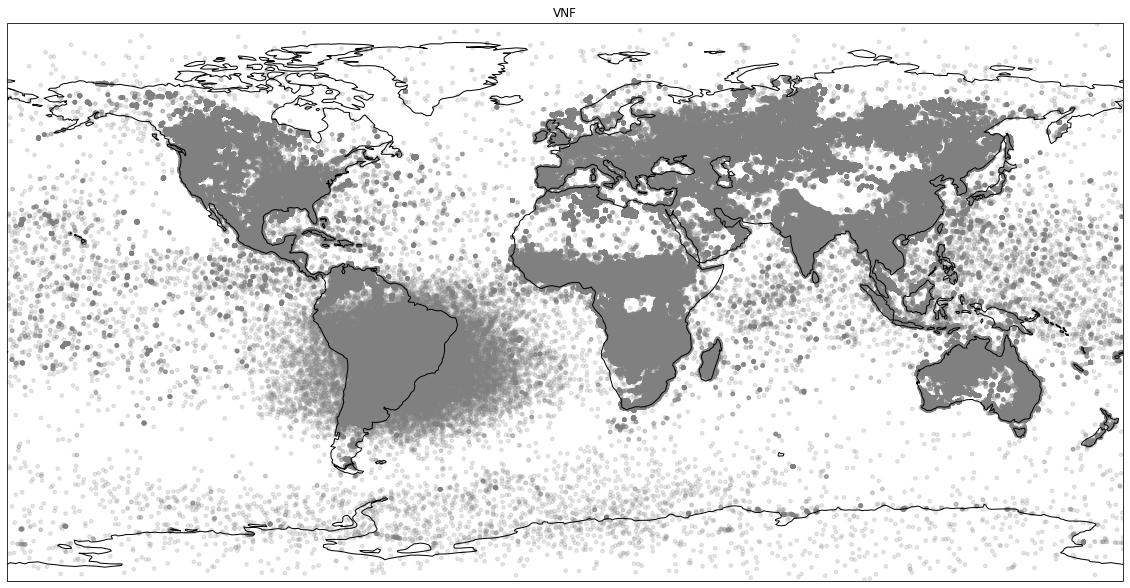

In [ ]:
ax2 = plt.axes(projection=ccrs.PlateCarree())
plt.title('VNF')
ax2.coastlines(resolution='110m')
plt.scatter(vnf_long, vnf_lats, marker='o', color='gray', alpha=0.2, label='vnf', s=marker_size)
plt.show()

In [ ]:
def haversine_np( lat1, lon1,  lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
#     dlon = np.expand_dims(lon2,axis = 0) - np.expand_dims(lon1,axis = 1)
#     dlat = np.expand_dims(lat2,axis = 0) - np.expand_dims(lat1,axis = 1)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return min(km)
    
def haversine_np_2d(cords1, cords2):
    return haversine_np(cords1[0],cords1[1], cords2[0], cords2[1])

In [ ]:
osm_points = list(zip(df['latitude'], df['longitude']))
osm_points_np = np.array(osm_points)


In [ ]:
tree = cKDTree(osm_points_np)
def close_to_osm_oil(row, radius = 1):
#     print(row)
    lat1 = row['Lat_GMTCO']
    lon1 = row['Lon_GMTCO']
    # Find k = 10 nearest neighbours in euclidean(!!!) distance
    dd, ii = tree.query(np.array([lat1,lon1]), k = 10)
    # Check if the spherical closest neighbour among the k = 10 euclidean nearest neighbours 
    # is nearer than 'radius' kilometres
    if haversine_np(lat1, lon1,osm_points_np[ii][:,0],osm_points_np[ii][:,1]) <= radius :
        return True
    else :
        return False


In [ ]:

from tqdm import tqdm
tqdm.pandas(desc="my bar!")
is_close = vnf_df.progress_apply(close_to_osm_oil, axis = 1)

my bar!:  79%|███████▉  | 2634883/3332951 [04:27<01:16, 9126.77it/s] 

In [ ]:
vnf_close_to_osm = vnf_df[is_close]
close_points_lat = vnf_close_to_osm['Lat_GMTCO']

close_points_lon = vnf_close_to_osm['Lon_GMTCO']

In [ ]:
ax3 = plt.axes(projection=ccrs.PlateCarree())
plt.title('VNF Close to Oil Fields')
ax3.coastlines(resolution='110m')
plt.scatter(close_points_lon, close_points_lat, marker='o', color='gray', alpha=0.2, label='vnf')
plt.show()

In [1]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Locations of Interest')
ax.coastlines(resolution='110m')
plt.scatter(long_of, lat_of, marker='x', color='red', label='Oil Field')
plt.scatter(long_rig, lat_rig, marker='x', color='blue', label='Oil Rig')
plt.scatter(long_op, lat_op, marker='x', color='yellow', label='Oil Platform')
plt.scatter(long_f, lat_f, marker='x', color='green', label='Flare')
plt.scatter(long_uk, lat_uk, marker='x', color='black', label='Unknown')
plt.scatter(long_gf, lat_gf, marker='x', color='orange', label='Gas Field')
plt.scatter(close_points_lon, close_points_lat, marker='o', color='gray', alpha=0.1, label='vnf')

plt.legend()
plt.show()

NameError: ignored